## Import Required Libraries

In [1]:
# Standard Libraries

import zipfile
from math import sqrt

# Data Handling

import pandas as pd
import numpy as np
from pandas import Timestamp
import joblib

# Statistical Modeling

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Machine Learning

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBRegressor

# Visualization

import matplotlib.pyplot as plt
import seaborn as sns

# Utilities

import logging
import warnings
warnings.filterwarnings("ignore")


## Read the Inputs

In [2]:
# Configuring logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Path to the zip file

zip_file_path = 'Assessment_Data.zip'

def load_data_from_zip(zip_file_path, file_name, data_format='csv'):
    """
    Loads a specific file from a ZIP archive.

    Parameters:
        zip_file_path (str): The path to the ZIP file.
        file_name (str): The name of the file to be loaded from the ZIP.
        data_format (str): The format of the file to be loaded. Defaults to 'csv'.

    Returns:
        DataFrame: A pandas DataFrame containing the loaded data.
    """
    try:
        with zipfile.ZipFile(zip_file_path, 'r') as z:
            with z.open(file_name) as f:
                if data_format == 'csv':
                    return pd.read_csv(f)
    except FileNotFoundError:
        logging.error(f"The file {file_name} not found in the ZIP archive.")
        return None
    except zipfile.BadZipFile:
        logging.error(f"File {zip_file_path} is not a ZIP file or it is corrupted.")
        return None

booking_data = load_data_from_zip(zip_file_path, 'booking_data.csv')
ad_data = load_data_from_zip(zip_file_path, 'ad_data.csv')
external_data = load_data_from_zip(zip_file_path, 'external_data.csv')

if booking_data is not None:
    logging.info("Booking data loaded successfully.")
if ad_data is not None:
    logging.info("Ad data loaded successfully.")
if external_data is not None:
    logging.info("External data loaded successfully.")


2024-04-28 21:02:47,684 - INFO - Booking data loaded successfully.
2024-04-28 21:02:47,684 - INFO - Ad data loaded successfully.
2024-04-28 21:02:47,684 - INFO - External data loaded successfully.


## Summary Statistics

In [3]:
def generate_summary_statistics(data):
    """
    Generate summary statistics and null value counts for a given dataset.

    Parameters:
        data (DataFrame): The dataset.

    Returns:
        dict: A dictionary containing summary statistics and null value counts.
    """
    summary_stats = data.describe()
    
    null_values = data.isnull().sum()
    
    results = {
        'Summary Statistics': summary_stats,
        'Null Value Counts': null_values
    }
    
    return results

In [4]:
results = generate_summary_statistics(booking_data)
print("Summary Statistics:")
print(results['Summary Statistics'])
print("\nNull Value Counts:")
print(results['Null Value Counts'])

Summary Statistics:
          location  city_locations       covers   menu_price  lifecycle_day
count  2285.000000     2285.000000  2285.000000  2243.000000    2243.000000
mean      3.492341        1.442013   137.676149    39.806063      20.012483
std       1.683223        0.566724    88.375637     4.787204      12.016300
min       1.000000        0.000000     0.000000    32.000000       0.000000
25%       2.000000        1.000000    71.000000    37.000000      10.000000
50%       3.000000        1.000000   137.000000    40.000000      20.000000
75%       5.000000        2.000000   196.000000    45.000000      30.000000
max       6.000000        2.000000   413.000000    45.000000      41.000000

Null Value Counts:
location           0
city               0
date               0
city_locations     0
covers             0
product           42
menu_price        42
lifecycle_day     42
dtype: int64


In [5]:
results = generate_summary_statistics(ad_data)
print("Ad Data Summary Statistics:")
print(results['Summary Statistics'])
print("\nNull Value Counts:")
print(results['Null Value Counts'])

Ad Data Summary Statistics:
             13_17        18_24        25_34        35_44        45_54  \
count  1021.000000  1021.000000  1021.000000  1021.000000  1021.000000   
mean      0.009381    18.004537    53.860553    31.610872    21.045250   
std       0.006499     6.098872    39.718497    21.405626    14.254266   
min       0.000896    10.195917     2.239430     1.026422     2.044104   
25%       0.005988    14.351341    28.491898    20.277358    11.290824   
50%       0.007794    16.776544    44.395076    25.866256    17.173220   
75%       0.010727    20.225726    67.661949    37.407080    26.542232   
max       0.099390    97.146286   507.630571   298.387318   148.543540   

             55_64       65_ovr      age_unk  audience_network      desktop  \
count  1021.000000  1021.000000  1021.000000       1021.000000  1021.000000   
mean     34.219642    15.244595     0.001883          5.353504     4.224929   
std      10.451031     3.316827     0.000691          3.668327     1

In [6]:
results = generate_summary_statistics(external_data)
print("External Data Summary Statistics:")
print(results['Summary Statistics'])
print("\nNull Value Counts:")
print(results['Null Value Counts'])

External Data Summary Statistics:
         location  urban_city_and_town_sparse_setting  cosmopolitans  \
count  265.000000                               212.0     212.000000   
mean     4.000000                                 0.0       0.866111   
std      1.416889                                 0.0       0.110816   
min      2.000000                                 0.0       0.719490   
25%      3.000000                                 0.0       0.779099   
50%      4.000000                                 0.0       0.883853   
75%      5.000000                                 0.0       0.970865   
max      6.000000                                 0.0       0.977248   

             temp  hpi_averageprice    labour_emp  
count  106.000000        212.000000  2.120000e+02  
mean     9.801617     358422.166649  2.961792e+07  
std      4.473275     171759.394935  1.888162e+05  
min     -2.642857     177056.678500  2.923957e+07  
25%      6.478571     189370.000000  2.946776e+07  
50%  

## Exploratory Data Analysis

In [7]:
# Converting Date feature into datetime format

booking_data['date'] = pd.to_datetime(booking_data['date'])
ad_data['date'] = pd.to_datetime(ad_data['date'])
external_data['week'] = pd.to_datetime(external_data['week'])

#### checking the total ad spend for the entire year

In [8]:
# Prepare data for plotting

age_group_columns = ['13_17', '18_24', '25_34', '35_44', '45_54', '55_64', '65_ovr']
platform_columns = ['facebook', 'instagram', 'messenger', 'audience_network', 'desktop', 
                    'mobile_app', 'mobile_web']

In [9]:
def plot_ad_spend(data, categories, title, xlabel, ylabel, rotation=45, color='skyblue'):
    """
    Plot ad spend distribution for given categories.

    Parameters:
        data (Series): Data to plot.
        categories (list): List of category names.
        title (str): Title of the plot.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        rotation (int): Degrees to rotate x-axis labels. Default is 45.
        color (str): Color of the bars.
    """
    plt.bar(categories, data, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotation)

    for i, value in enumerate(data):
        plt.text(i, value, round(value, 2), va='bottom', ha='center')

def create_ad_spend_plots(ad_data, age_group_columns, platform_columns):
    """
    Create comparative analysis plots of ad expenditures by age group and platform.

    Parameters:
        ad_data (DataFrame): Advertising data.
        age_group_columns (list): Column names for age groups.
        platform_columns (list): Column names for platforms.
    """
    age_group_spend = ad_data[age_group_columns].sum()
    platform_spend = ad_data[platform_columns].sum()

    plt.figure(figsize=(14, 6))
    plt.suptitle('Comparative Analysis of Advertising Expenditures by Age Group and Platform per year', 
                 fontsize=16)

    # Age Group Spend Plot
    plt.subplot(1, 2, 1)
    plot_ad_spend(age_group_spend, age_group_columns, 
                  'Ad Spend Distribution Across Age Groups', 'Age Groups', 
                  'Total Ad Spend', color='skyblue')

    # Platform Spend Plot
    plt.subplot(1, 2, 2)
    plot_ad_spend(platform_spend, platform_columns,
                  'Ad Spend Distribution Across Platforms',
                  'Platforms', 'Total Ad Spend', color='coral')

    plt.tight_layout()
    plt.show()

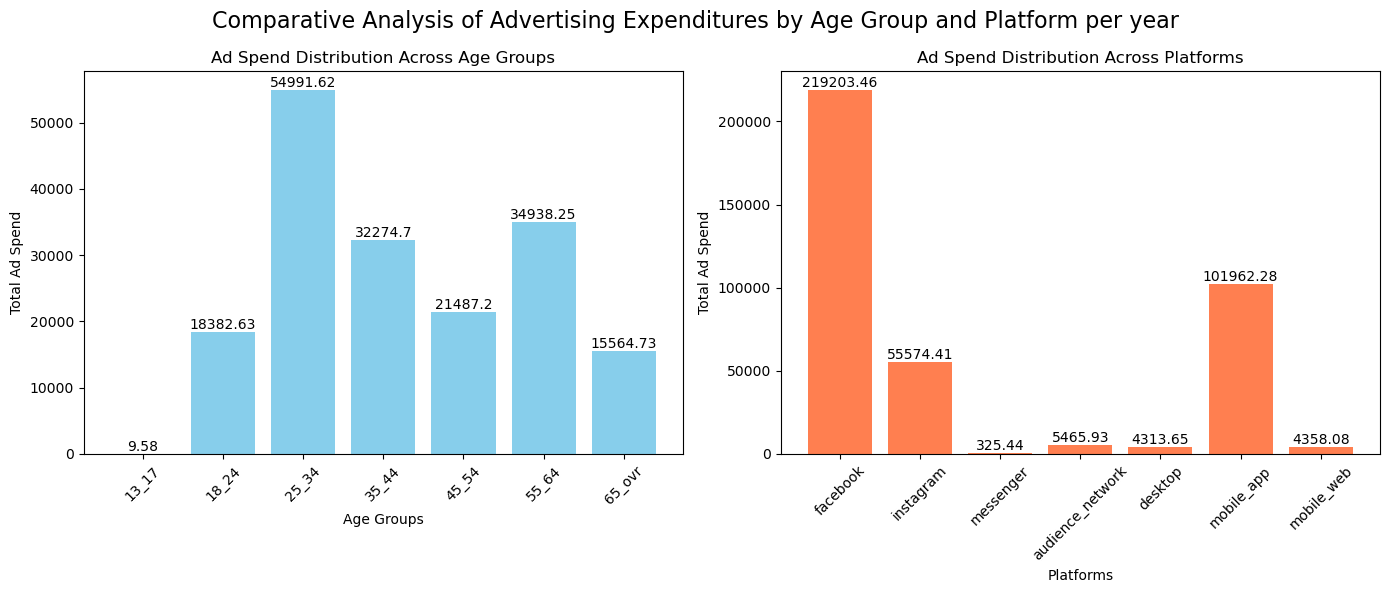

In [10]:
create_ad_spend_plots(ad_data, age_group_columns, platform_columns)

#### Checking for "month" and "city" wide distributions of various features

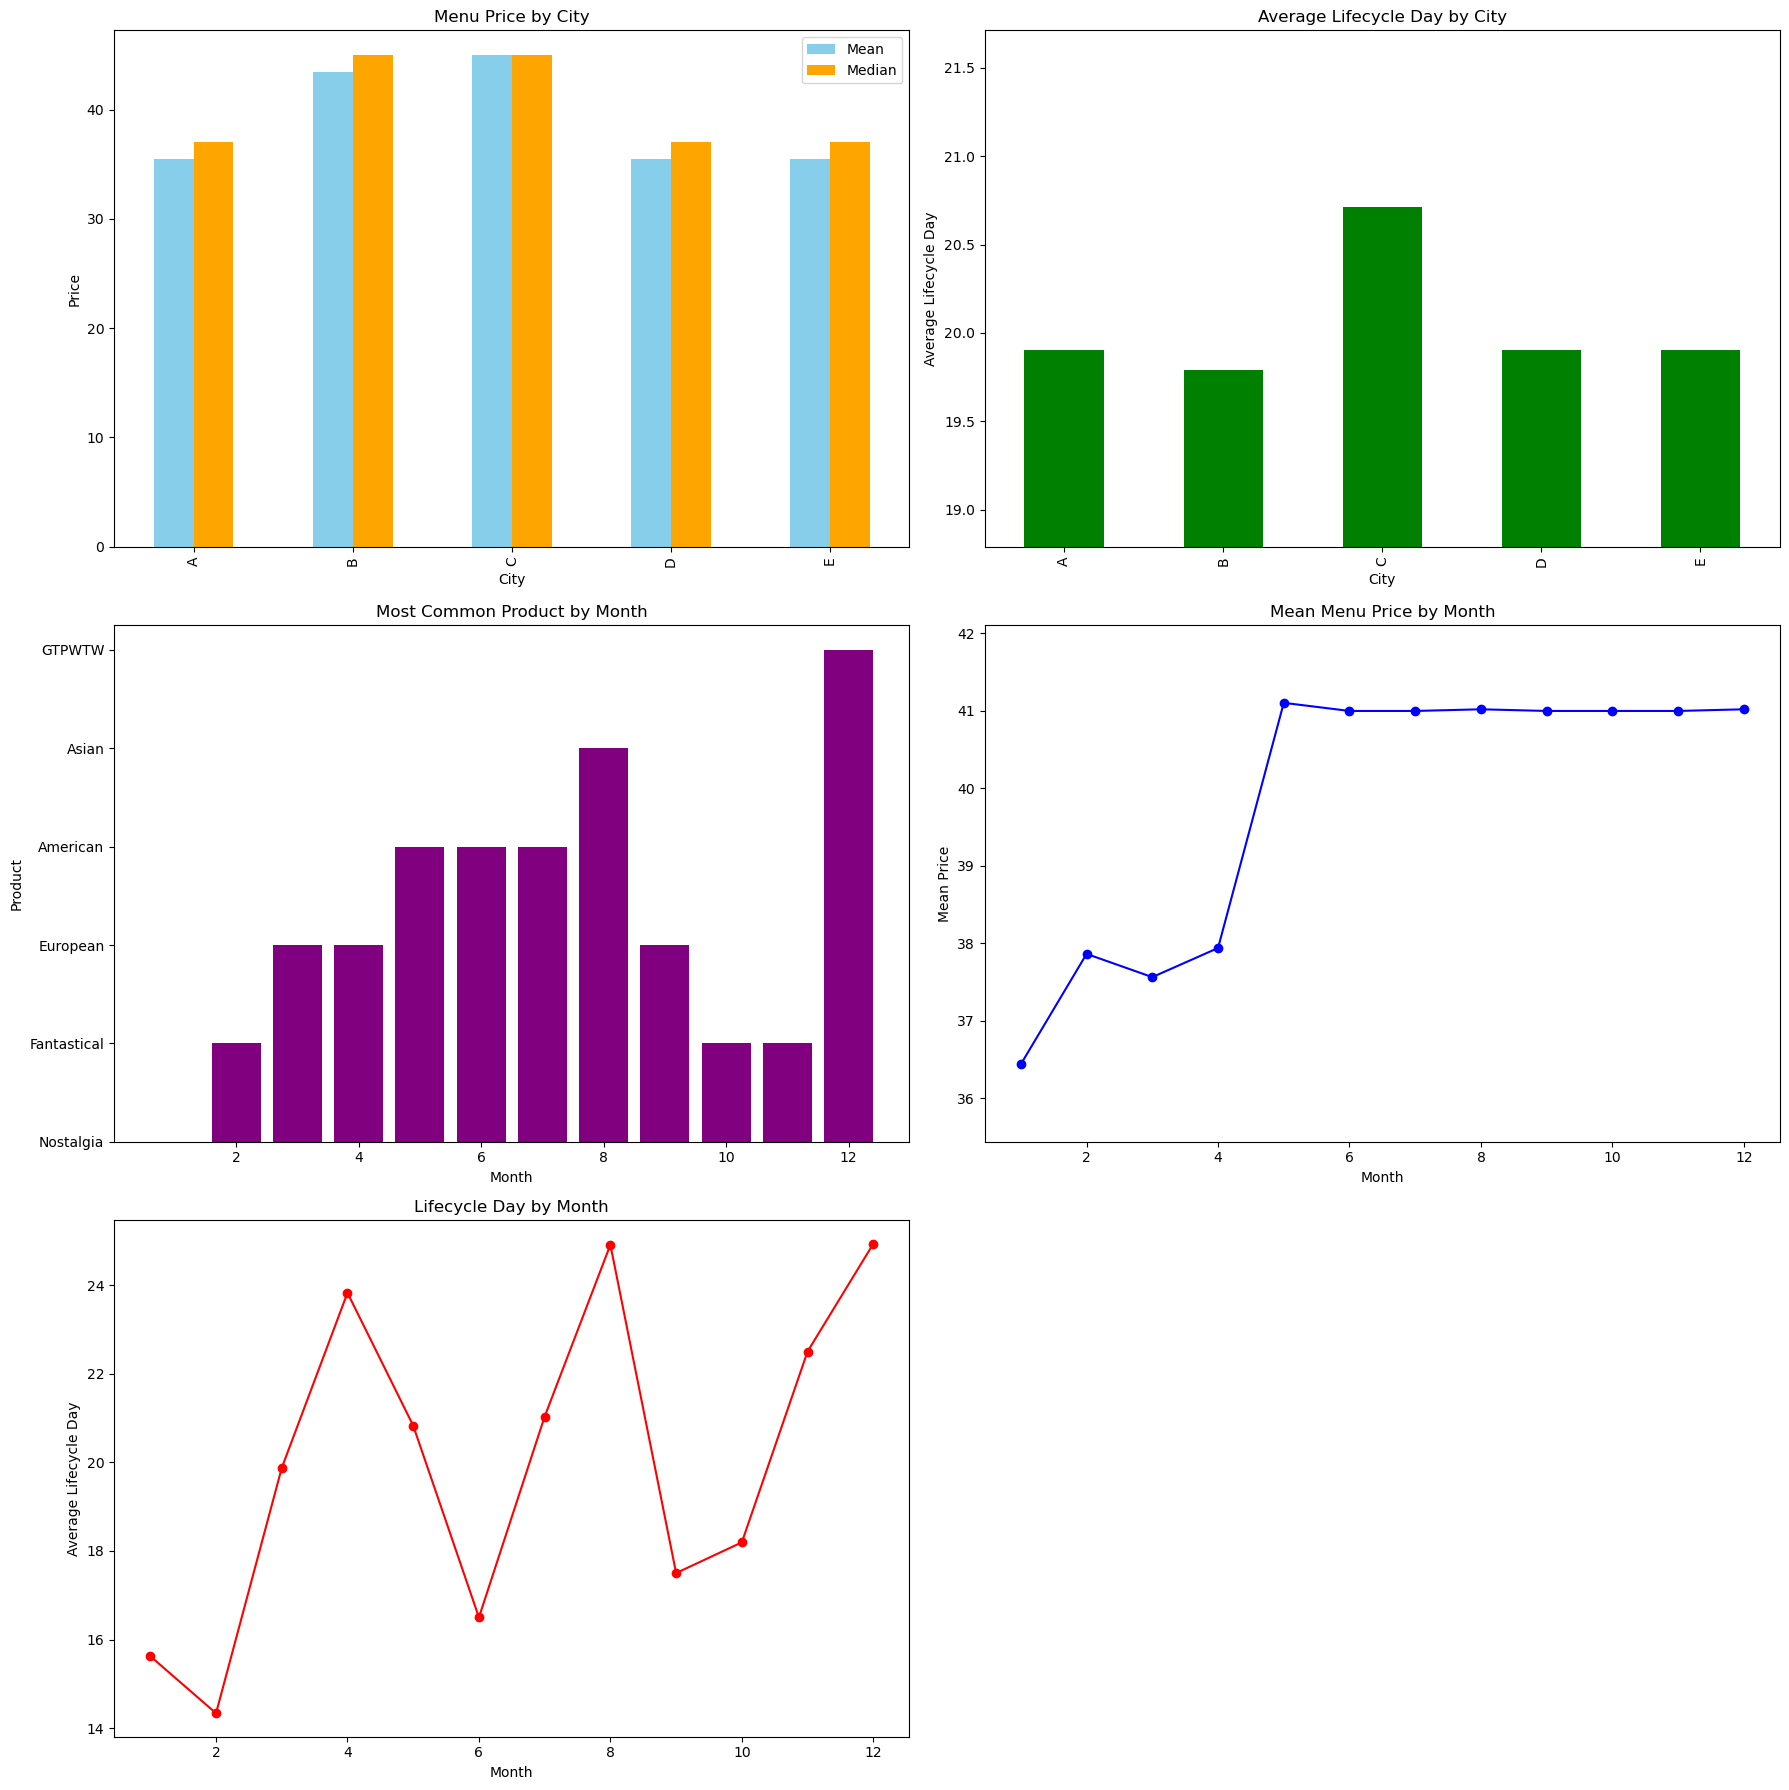

In [11]:
booking_data['month'] = booking_data['date'].dt.month

# creating aggregation rules

aggregation_rules = {
    'menu_price': ['mean', 'median', 'std'],
    'lifecycle_day': ['mean', 'median', 'std'],
    'product': lambda x: x.mode()[0]  # Most common product
}

# Grouping by city and month

grouped_city = booking_data.groupby('city').agg(aggregation_rules).rename(columns={
    'mean': 'Mean', 'median': 'Median', 'std': 'Std', '<lambda>': 'Most Common Product'
})
grouped_month = booking_data.groupby('month').agg(aggregation_rules).rename(columns={
    'mean': 'Mean', 'median': 'Median', 'std': 'Std', '<lambda>': 'Most Common Product'
})

# Plotting
fig, axes = plt.subplots(3, 2, figsize=(18, 18))

# Menu Price by City

grouped_city['menu_price'][['Mean', 'Median']].plot(kind='bar', ax=axes[0, 0], 
                                                    color=['skyblue', 'orange'])
axes[0, 0].set_title('Menu Price by City')
axes[0, 0].set_ylabel('Price')
axes[0, 0].set_xlabel('City')

# Lifecycle Day by City

grouped_city['lifecycle_day']['Mean'].plot(kind='bar', ax=axes[0, 1], color='green')
axes[0, 1].set_title('Average Lifecycle Day by City')
axes[0, 1].set_ylabel('Average Lifecycle Day')
axes[0, 1].set_xlabel('City')
axes[0, 1].set_ylim([grouped_city['lifecycle_day']['Mean'].min() - 1, 
                     grouped_city['lifecycle_day']['Mean'].max() + 1])

# Product Distribution by Month

axes[1, 0].bar(grouped_month.index, grouped_month['product']['Most Common Product'], color='purple')
axes[1, 0].set_title('Most Common Product by Month')
axes[1, 0].set_ylabel('Product')
axes[1, 0].set_xlabel('Month')

# Menu Price by Month

grouped_month['menu_price']['Mean'].plot(ax=axes[1, 1], marker='o', linestyle='-', color='blue')
axes[1, 1].set_title('Mean Menu Price by Month')
axes[1, 1].set_ylabel('Mean Price')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylim([grouped_month['menu_price']['Mean'].min() - 1, 
                     grouped_month['menu_price']['Mean'].max() + 1])

# Lifecycle Day by Month

grouped_month['lifecycle_day']['Mean'].plot(ax=axes[2, 0], marker='o', linestyle='-', color='red')
axes[2, 0].set_title('Lifecycle Day by Month')
axes[2, 0].set_ylabel('Average Lifecycle Day')
axes[2, 0].set_xlabel('Month')

# Hide unused subplot

axes[2, 1].set_visible(False)

plt.tight_layout()
plt.show()

#### Checking "covers" trend over different location

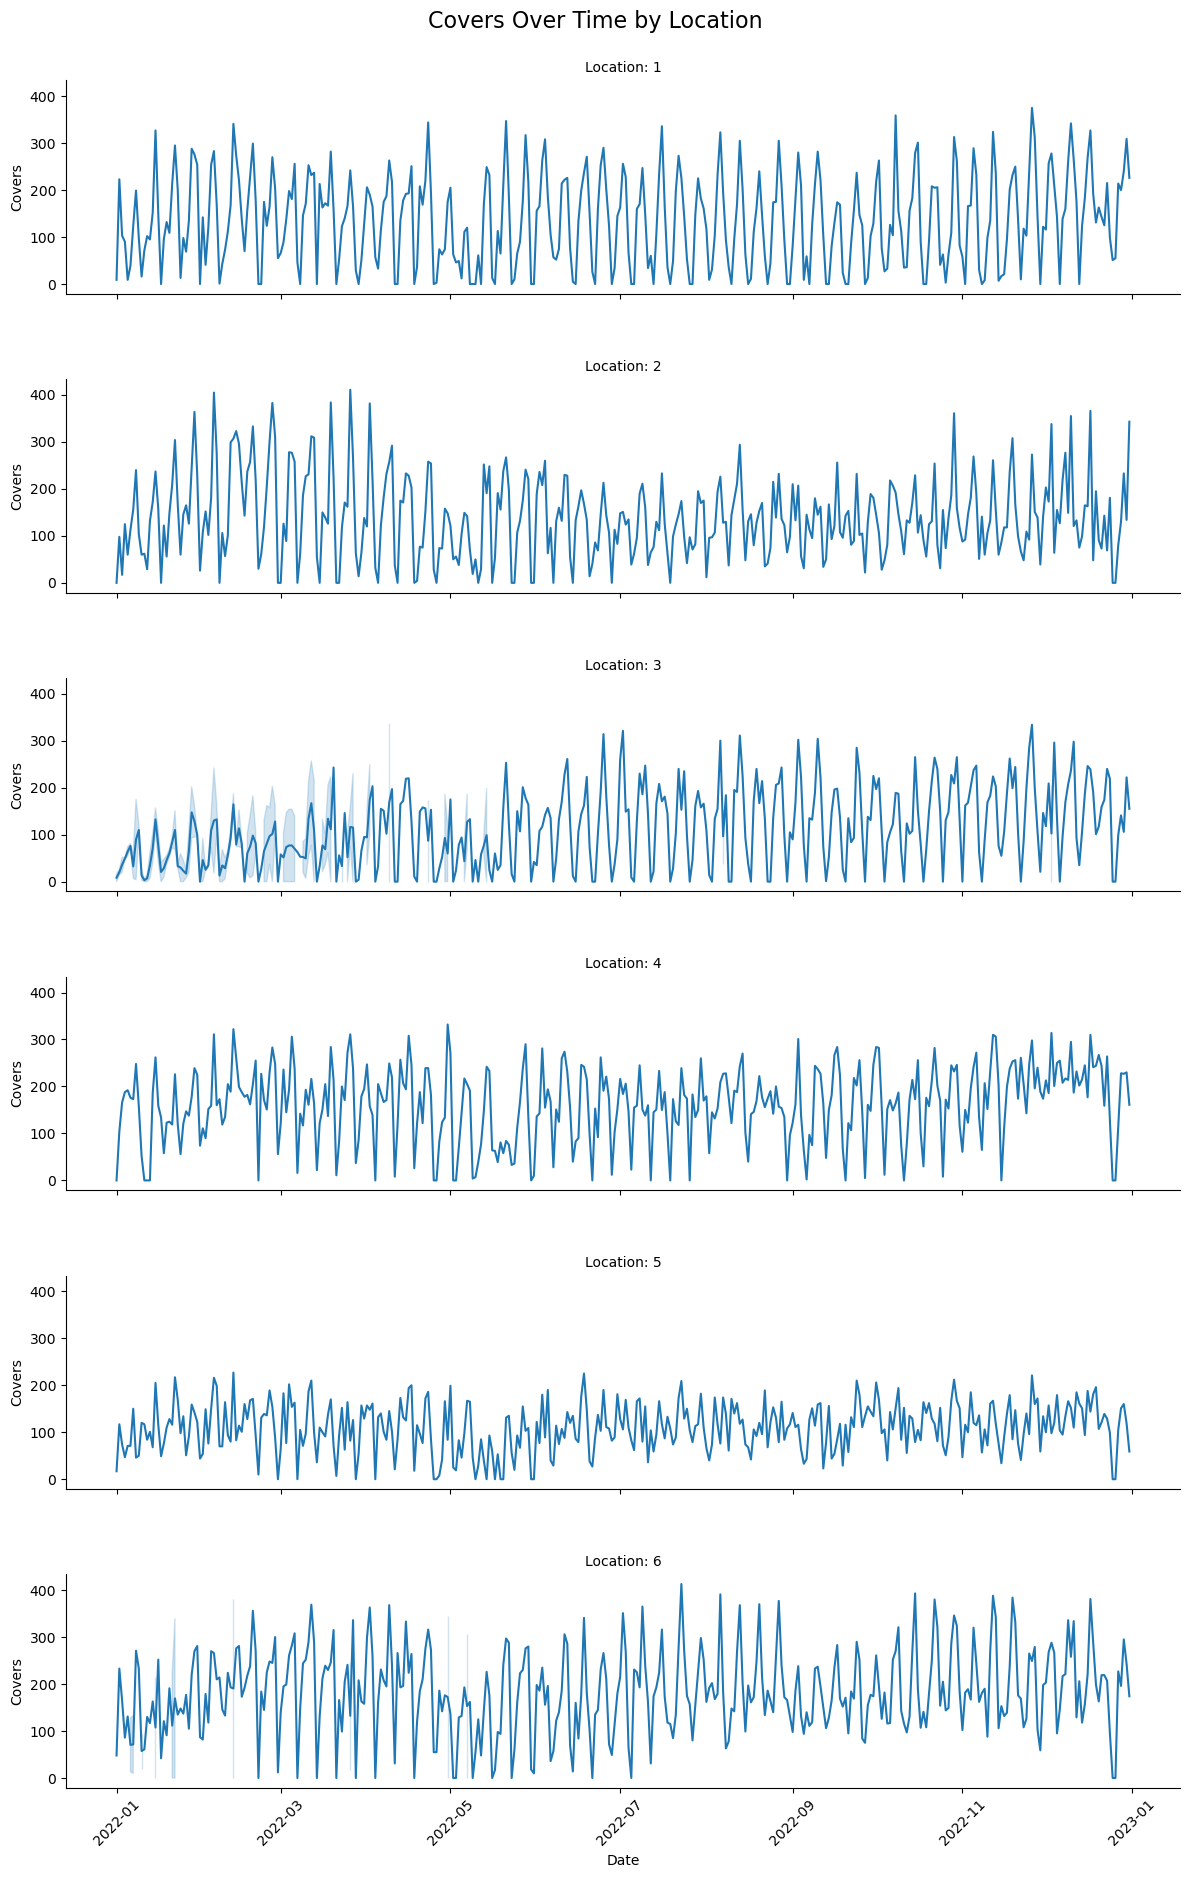

In [12]:
g = sns.FacetGrid(booking_data, row="location", height=3, aspect=4)
g.map_dataframe(sns.lineplot, 'date', 'covers')

g.set_titles("Location: {row_name}")
g.set_axis_labels("Date", "Covers")

# Rotate x-axis labels for better visibility; it is applied on each facet of the grid

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.subplots_adjust(hspace=0.4)

g.fig.suptitle('Covers Over Time by Location', fontsize=16, y=1.02)

plt.show()

#### Checking for Seasonal Decomposition

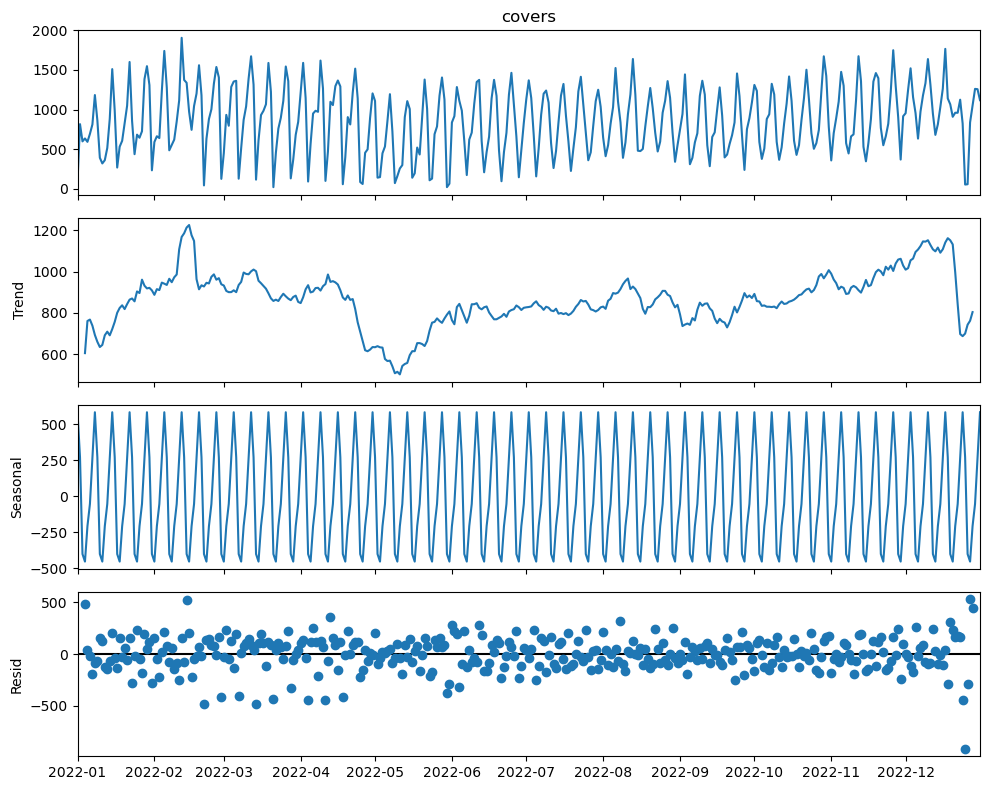

In [13]:
booking_data.sort_values('date', inplace=True)

daily_data = booking_data.groupby('date')['covers'].sum()

decomposition = seasonal_decompose(daily_data, model='additive', period=7)

# Plot the seasonal decomposition

fig = decomposition.plot()
fig.set_size_inches(10, 8)
fig.tight_layout()
plt.show()

#### Checking for Autocorrelation and Partial Autocorrelation

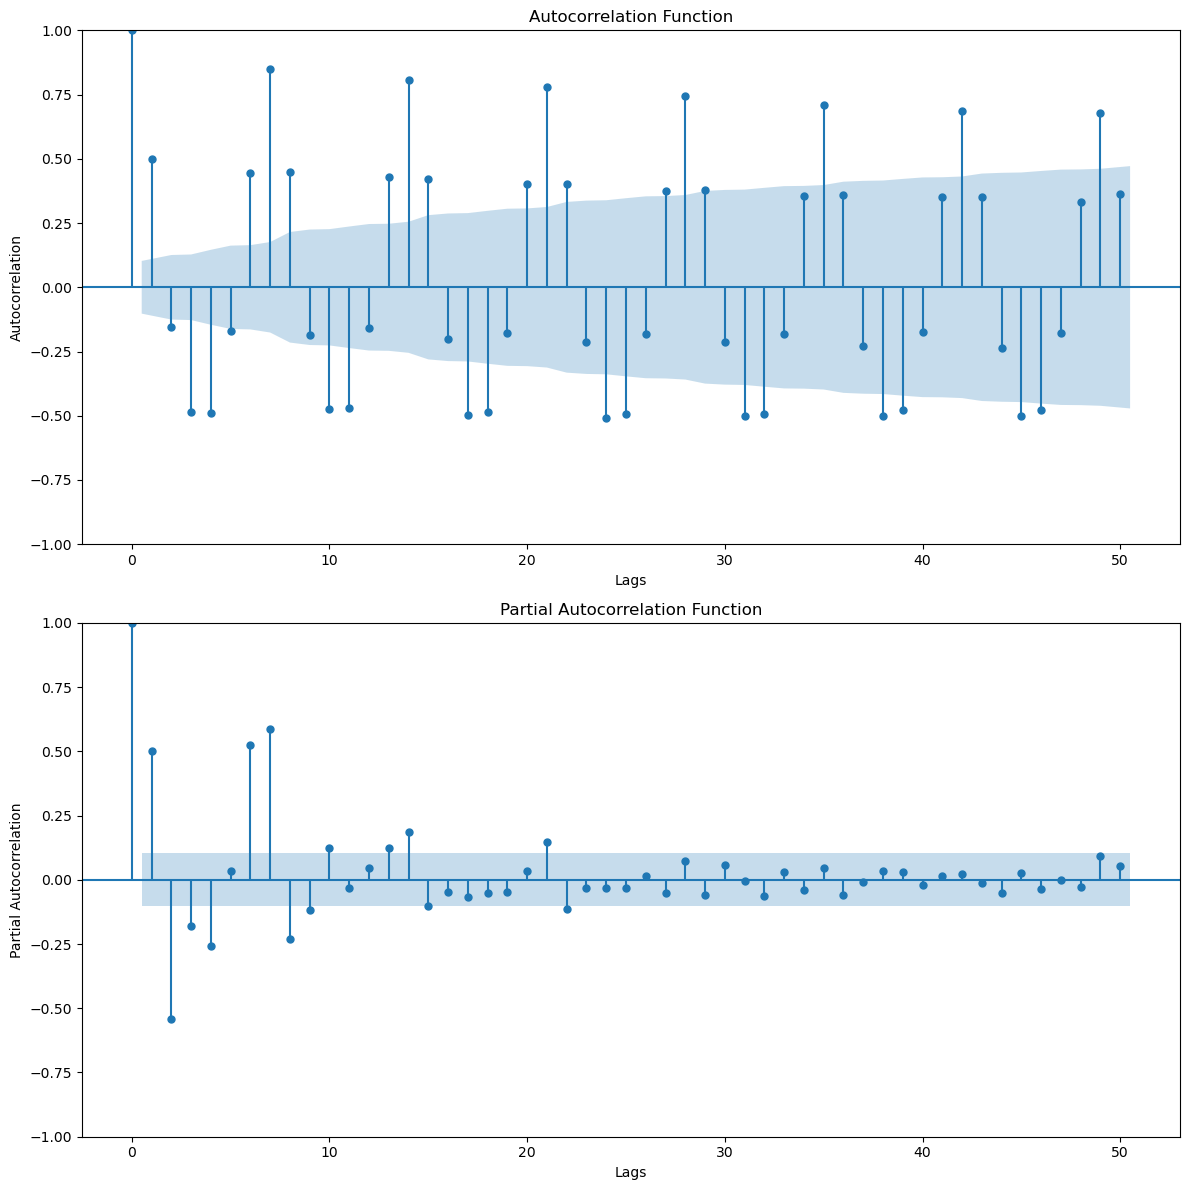

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# Plot ACF: Autocorrelation Function

plot_acf(daily_data, lags=50, ax=ax[0], alpha=0.05)
ax[0].set_title('Autocorrelation Function')
ax[0].set_xlabel('Lags')
ax[0].set_ylabel('Autocorrelation')

# Plot PACF: Partial Autocorrelation Function

plot_pacf(daily_data, lags=50, ax=ax[1], alpha=0.05)
ax[1].set_title('Partial Autocorrelation Function')
ax[1].set_xlabel('Lags')
ax[1].set_ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.show()

#### Dickey–Fuller Test : Check for stationarity

In [15]:
time_series_data = booking_data.groupby('date')['covers'].sum().reset_index()
time_series_data.set_index('date', inplace=True)
time_series_data.sort_index(inplace=True) 

# Check for duplicate dates which can disrupt many time series analyses

if time_series_data.index.duplicated().any():
    print("Warning: Duplicate dates found. Consider aggregating or removing duplicates.")
else:
    print("No duplicate dates found.")

covers_series = time_series_data['covers']

dickey_fuller_result = adfuller(covers_series.dropna(), autolag='AIC')

df_output = pd.Series(dickey_fuller_result[0:4], index=['Test Statistic', 'p-value',
                                                        '#Lags Used', 'Number of Observations Used'])
for key, value in dickey_fuller_result[4].items():
    df_output['Critical Value (%s)' % key] = value

df_output

No duplicate dates found.


Test Statistic                  -2.519579
p-value                          0.110783
#Lags Used                      14.000000
Number of Observations Used    350.000000
Critical Value (1%)             -3.449173
Critical Value (5%)             -2.869833
Critical Value (10%)            -2.571188
dtype: float64

#### Ljung-Box Test: Check for Autocorrelation

In [16]:
lags_to_test = [1, 5, 10, 15, 20]
ljung_box_result_multiple_lags = acorr_ljungbox(booking_data['covers'], lags=lags_to_test,
                                                return_df=True)

ljung_box_result_multiple_lags

,lb_stat,lb_pvalue
1,435.234294,1.179398e-96
5,1534.723971,0.000000e+00
10,1889.731168,0.000000e+00
15,1968.563836,0.000000e+00
20,2504.330828,0.000000e+00


## Feature Engineering

#### Booking Data

In [17]:
# Impute missing values: median for continuos features and mode of categorical features

booking_data['menu_price'].fillna(booking_data['menu_price'].median(), inplace=True)
booking_data['lifecycle_day'].fillna(booking_data['lifecycle_day'].median(), inplace=True)

product_mode = booking_data['product'].mode()[0]

booking_data['product'].fillna(product_mode, inplace=True)

# Function to convert date to week starting on Monday

def date_to_week(date):
    week_start = date - pd.Timedelta(days=date.weekday())
    date_new = week_start.strftime("%d/%m/%Y")
    return pd.to_datetime(date_new)

booking_data['week'] = booking_data['date'].apply(date_to_week)

# Adding additional temporal features

booking_data['day_of_week'] = booking_data['date'].dt.dayofweek
booking_data['quarter'] = booking_data['date'].dt.quarter
booking_data['day'] = booking_data['date'].dt.day
booking_data['is_weekend'] = booking_data['day_of_week'].isin([5, 6]).astype(int)
booking_data['year'] = booking_data['date'].dt.year
booking_data['dayofyear'] = booking_data['date'].dt.dayofyear
booking_data['weekofyear'] = booking_data['date'].dt.isocalendar().week


#### Ad Data

In [18]:
# upending "_spend" to all the ad data columns and creating additional interactive features

age_groups = ['13_17', '18_24', '25_34', '35_44', '45_54', '55_64', '65_ovr', 'age_unk']
platforms = ['audience_network', 'desktop', 'device_unk', 'facebook', 'instagram', 'messenger', 'mobile_app', 
             'mobile_web', 'platform_unk']

grouped_spend = ad_data.groupby(['city', 'date'])[age_groups + platforms].sum().reset_index()

ad_data = ad_data.merge(grouped_spend, on=['city', 'date'], how='left', suffixes=('', '_spend'))

ad_data['total_social_spend'] = ad_data[['facebook_spend', 'instagram_spend', 'messenger_spend']].sum(axis=1)
ad_data['total_mobile_spend'] = ad_data[['mobile_app_spend', 'mobile_web_spend']].sum(axis=1)
ad_data['total_age_category_spend'] = ad_data[['13_17_spend', '18_24_spend', '25_34_spend', '35_44_spend', 
                                               '45_54_spend', '55_64_spend', '65_ovr_spend', 
                                               'age_unk_spend']].sum(axis=1)

others = ad_data[['audience_network','desktop','device_unk','platform_unk']].sum(axis=1)
ad_data['total_spend'] = (ad_data['total_social_spend'] + ad_data['total_mobile_spend'] 
                          + ad_data['total_age_category_spend'] + others)

ad_data.drop(columns=['13_17', '18_24', '25_34', '35_44', '45_54', '55_64', '65_ovr', 'age_unk',
                     'audience_network', 'desktop', 'device_unk', 'facebook', 'instagram', 
                      'messenger', 'mobile_app', 'mobile_web','platform_unk'], axis = 1, inplace = True)

#### External Data

In [19]:
# filling all the missing values of Continuous variables with median

numeric_columns_external = external_data.select_dtypes(include=['float64', 'int64']).columns
median_values_external = external_data[numeric_columns_external].median()
external_data[numeric_columns_external] = external_data[numeric_columns_external].fillna(median_values_external)

In [20]:
# Merging all the dataframes

merged_data = pd.merge(booking_data, ad_data, on=['date', 'city'], how='left')
final_merged_data = pd.merge(merged_data, external_data, on=['week', 'location'], how='left')

In [21]:
final_merged_data.isnull().sum()

location                                0
city                                    0
date                                    0
city_locations                          0
covers                                  0
product                                 0
menu_price                              0
lifecycle_day                           0
month                                   0
week                                    0
day_of_week                             0
quarter                                 0
day                                     0
is_weekend                              0
year                                    0
dayofyear                               0
weekofyear                              0
spend                                 965
13_17_spend                           965
18_24_spend                           965
25_34_spend                           965
35_44_spend                           965
45_54_spend                           965
55_64_spend                       

In [22]:
# Filling NaN values for spend columns with 0 because no spend data means zero ad spend for that day in the city

spend_columns = [col for col in final_merged_data.columns if 'spend' in col]
final_merged_data[spend_columns] = final_merged_data[spend_columns].fillna(0)

In [23]:
# Creating additional interactive features

# Ad Spend per Location

final_merged_data['ad_spends_per_location'] = final_merged_data.groupby(['location', 'date']
                                                                       )['total_spend'].transform('sum')

# Revenue Potential

final_merged_data['revenue_potential'] = final_merged_data['menu_price'] * final_merged_data['covers']

# Average Spend Per Cover

final_merged_data['average_spends_per_cover'] = final_merged_data['total_spend'] / final_merged_data['covers']

# Return on Ad Spend (ROAS)

final_merged_data['ROAS'] = final_merged_data['revenue_potential'] / final_merged_data['total_spend']

final_merged_data['covers_interaction_over_weekend'] = final_merged_data['covers'] * final_merged_data['is_weekend']
final_merged_data['covers_interaction_day_of_week'] = final_merged_data['covers'] * final_merged_data['day_of_week']

# Binning Menu Price into three segments

menu_price_bins = [31, 36, 41, 46] 
bin_labels = ['Low', 'Medium', 'High']
final_merged_data['menu_price_segment'] = pd.cut(final_merged_data['menu_price'], bins=menu_price_bins, labels=bin_labels)

# # Display the dataframe with new features

final_merged_data[['ad_spends_per_location', 'revenue_potential', 'average_spends_per_cover', 'ROAS',
                   'menu_price_segment','covers_interaction_over_weekend','covers_interaction_day_of_week']].head(10)



,ad_spends_per_location,revenue_potential,average_spends_per_cover,ROAS,menu_price_segment,covers_interaction_over_weekend,covers_interaction_day_of_week
0,416.121358,288.0,46.235706,0.692106,Low,9,45
1,919.165436,765.0,27.034278,1.664553,High,17,85
2,443.272050,0.0,inf,0.000000,Low,0,0
3,0.000000,544.0,0.000000,inf,Low,17,85
4,919.165436,0.0,inf,0.000000,High,0,0
5,506.181858,0.0,inf,0.000000,Medium,0,0
6,506.181858,1920.0,10.545455,3.793103,Medium,48,240
7,1447.109665,1170.0,27.829032,1.617016,High,26,156
8,0.000000,3328.0,0.000000,inf,Low,104,624
9,364.000215,3744.0,3.111113,10.285708,Low,117,702


In [24]:
final_merged_data[['is_weekend', 'covers','day_of_week','covers_interaction_over_weekend','covers_interaction_day_of_week']].head(10)

,is_weekend,covers,day_of_week,covers_interaction_over_weekend,covers_interaction_day_of_week
0,1,9,5,9,45
1,1,17,5,17,85
2,1,0,5,0,0
3,1,17,5,17,85
4,1,0,5,0,0
5,1,0,5,0,0
6,1,48,5,48,240
7,1,26,6,26,156
8,1,104,6,104,624
9,1,117,6,117,702


In [25]:
# checking for any infinite values due to divisions and replacing them with zero:

final_merged_data['ROAS'].replace([np.inf, -np.inf], 0, inplace=True)
final_merged_data['average_spends_per_cover'].replace([np.inf, -np.inf], 0, inplace=True)

final_merged_data['average_spends_per_cover'] = final_merged_data['average_spends_per_cover'].fillna(0)
final_merged_data['ROAS'] = final_merged_data['ROAS'].fillna(0)

final_merged_data[['ad_spends_per_location', 'revenue_potential', 'average_spends_per_cover', 'ROAS',
                   'menu_price_segment']].head(10)

,ad_spends_per_location,revenue_potential,average_spends_per_cover,ROAS,menu_price_segment
0,416.121358,288.0,46.235706,0.692106,Low
1,919.165436,765.0,27.034278,1.664553,High
2,443.272050,0.0,0.000000,0.000000,Low
3,0.000000,544.0,0.000000,0.000000,Low
4,919.165436,0.0,0.000000,0.000000,High
5,506.181858,0.0,0.000000,0.000000,Medium
6,506.181858,1920.0,10.545455,3.793103,Medium
7,1447.109665,1170.0,27.829032,1.617016,High
8,0.000000,3328.0,0.000000,0.000000,Low
9,364.000215,3744.0,3.111113,10.285708,Low


#### Checking the features for correlation and multicollinearity

In [26]:
def analyze_correlation(data, variables_to_analyze):
    """
    Analyze and plot the correlation of specified variables with 'covers'.

    Parameters:
        data (DataFrame): The DataFrame containing the data.
        variables_to_analyze (list): A list of variable names to analyze.

    Returns:
        None
    """
    # Check if the specified variables exist in the DataFrame
    
    missing_columns = [col for col in variables_to_analyze if col not in data.columns]
    if missing_columns:
        print("Warning: Missing columns in DataFrame -", missing_columns)
        return

    columns_to_correlate = ['covers'] + variables_to_analyze

    selected_correlations = data[columns_to_correlate].corr()

    print("Correlation values with 'covers':")
    print(selected_correlations['covers'])

    # Plotting the correlations using a heatmap
    
    plt.figure(figsize=(15, 10))
    sns.heatmap(selected_correlations, annot=True, cmap='coolwarm', fmt=".2f",
                cbar_kws={'label': 'Correlation Coefficient'})
    plt.title('External Data Correlation Heatmap')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()  
    plt.show()

##### Correlation for external data features vs covers

Correlation values with 'covers':
covers              1.000000
cosmopolitans      -0.102778
temp               -0.057888
hpi_averageprice    0.131743
labour_emp          0.037611
Name: covers, dtype: float64


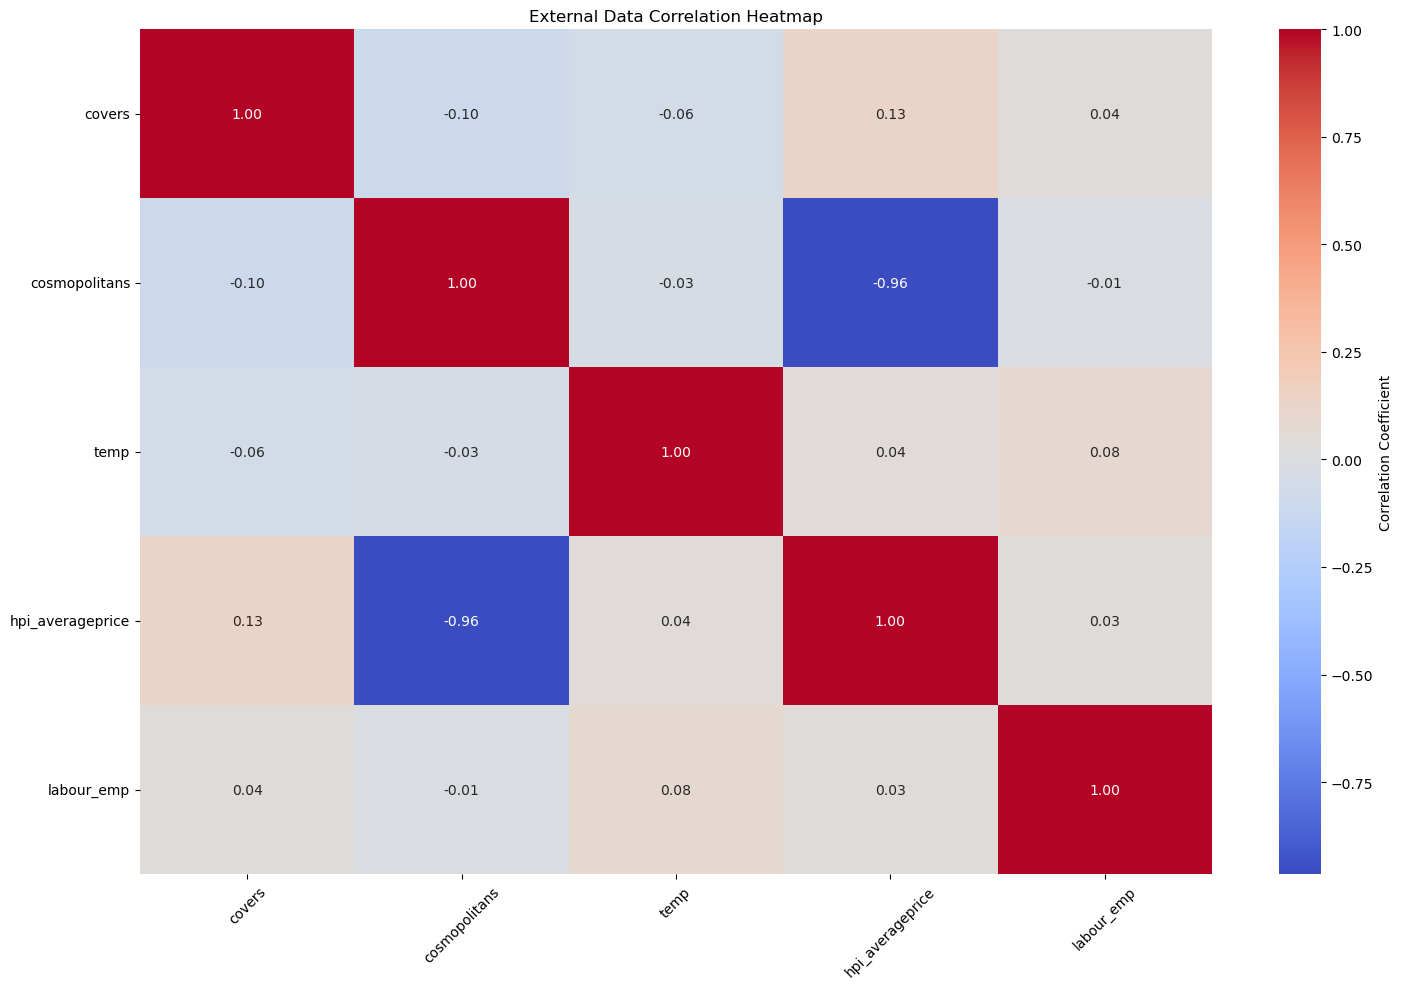

In [27]:
variables_to_analyze = ['cosmopolitans', 'temp', 'hpi_averageprice', 'labour_emp']
analyze_correlation(final_merged_data, variables_to_analyze)

##### Correlation for ad data features vs covers

Correlation values with 'covers':
covers                      1.000000
spend                       0.001487
13_17_spend                 0.017338
18_24_spend                -0.006044
25_34_spend                -0.003514
35_44_spend                -0.003782
45_54_spend                -0.013504
55_64_spend                -0.004815
65_ovr_spend                0.003546
age_unk_spend               0.014005
audience_network_spend     -0.033253
desktop_spend              -0.014042
device_unk_spend           -0.003039
facebook_spend              0.006937
instagram_spend             0.002795
messenger_spend            -0.027955
mobile_app_spend           -0.010482
mobile_web_spend           -0.028958
platform_unk_spend          0.006277
total_social_spend          0.006112
total_mobile_spend         -0.011552
total_age_category_spend   -0.005665
total_spend                -0.002218
Name: covers, dtype: float64


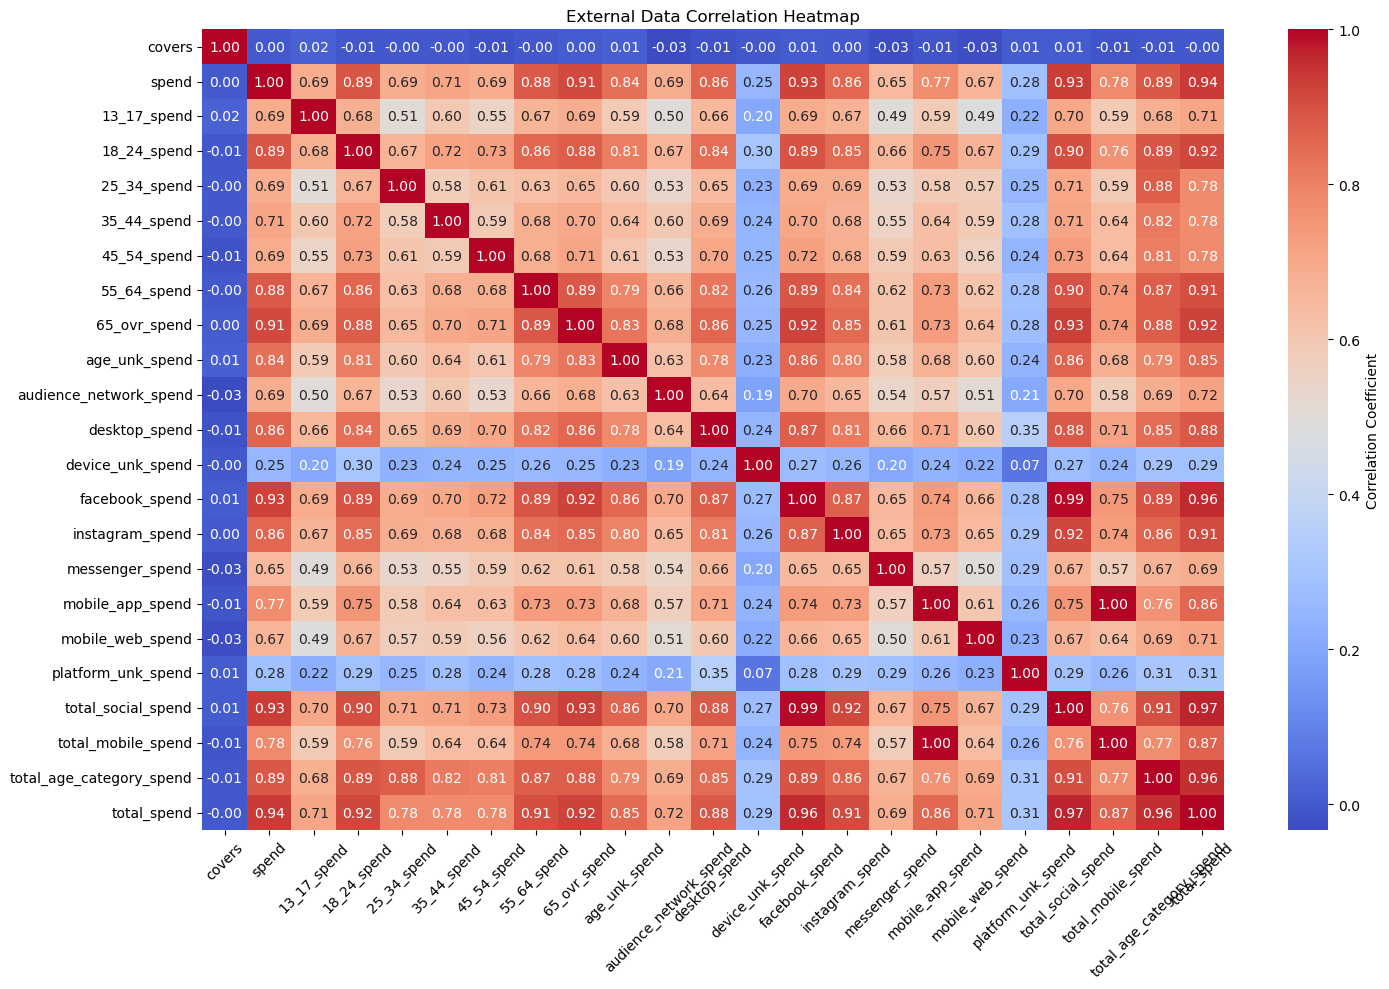

In [28]:
variables_to_analyze = ['spend', '13_17_spend', '18_24_spend', '25_34_spend', '35_44_spend',
                        '45_54_spend', '55_64_spend', '65_ovr_spend', 'age_unk_spend',
                        'audience_network_spend', 'desktop_spend', 'device_unk_spend',
                        'facebook_spend', 'instagram_spend', 'messenger_spend',
                        'mobile_app_spend', 'mobile_web_spend', 'platform_unk_spend',
                        'total_social_spend', 'total_mobile_spend', 'total_age_category_spend','total_spend']

analyze_correlation(final_merged_data, variables_to_analyze)

In [29]:
# Dropping few coloumns that are not significant and have multicollinearity

final_merged_data.drop(columns = ['urban_city_and_town_sparse_setting','cosmopolitans',
                                  'temp','hpi_averageprice', 'labour_emp', 'spend', '13_17_spend',
                                  '18_24_spend', '25_34_spend', '35_44_spend',
                                  '45_54_spend', '55_64_spend', '65_ovr_spend', 'age_unk_spend',
                                  'facebook_spend', 'instagram_spend', 'messenger_spend','desktop_spend',
                                  'mobile_app_spend', 'mobile_web_spend'], axis = 1, inplace = True)

#### Variation inflation factor: To check for multicollinearity of numeric features

In [30]:
def calculate_vif(data, exclude_columns_suffix=None):
    """
    Calculates Variance Inflation Factor (VIF) for each numeric column in a DataFrame,
    excluding columns based on a specific suffix.

    Parameters:
        data (DataFrame): The DataFrame containing the data.
        exclude_columns_suffix (str): Suffix of the columns to exclude from the VIF calculation.

    Returns:
        DataFrame: A DataFrame with the features and their corresponding VIFs, sorted in descending order.
    """
    # Select numeric columns and optionally exclude columns with a certain suffix
    
    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
    if exclude_columns_suffix:
        numeric_columns = [col for col in numeric_columns if not col.endswith(exclude_columns_suffix)]
    
    data_vif = data[numeric_columns]

    vif_values = [variance_inflation_factor(data_vif.values, i) for i in range(len(numeric_columns))]
    vif_df = pd.DataFrame({'feature': numeric_columns, 'VIF': vif_values})

    # Return the DataFrame sorted by VIF in descending order
    
    return vif_df.sort_values(by='VIF', ascending=False)

In [31]:
vif_results = calculate_vif(final_merged_data, exclude_columns_suffix='is_weekend')
print(vif_results)

                            feature            VIF
11                      total_spend  164695.229124
8                total_social_spend   38961.768209
10         total_age_category_spend   17106.967764
9                total_mobile_spend    7190.655350
13                revenue_potential      91.093253
2                            covers      90.368955
5            audience_network_spend      24.931538
12           ad_spends_per_location      21.002336
17   covers_interaction_day_of_week      20.585737
3                        menu_price      15.590993
1                    city_locations      11.399883
0                          location       6.822548
16  covers_interaction_over_weekend       5.844645
15                             ROAS       5.152928
4                     lifecycle_day       3.915736
14         average_spends_per_cover       1.350736
7                platform_unk_spend       1.272715
6                  device_unk_spend       1.192466


#### Principal Component Analysis: for all the spend variable

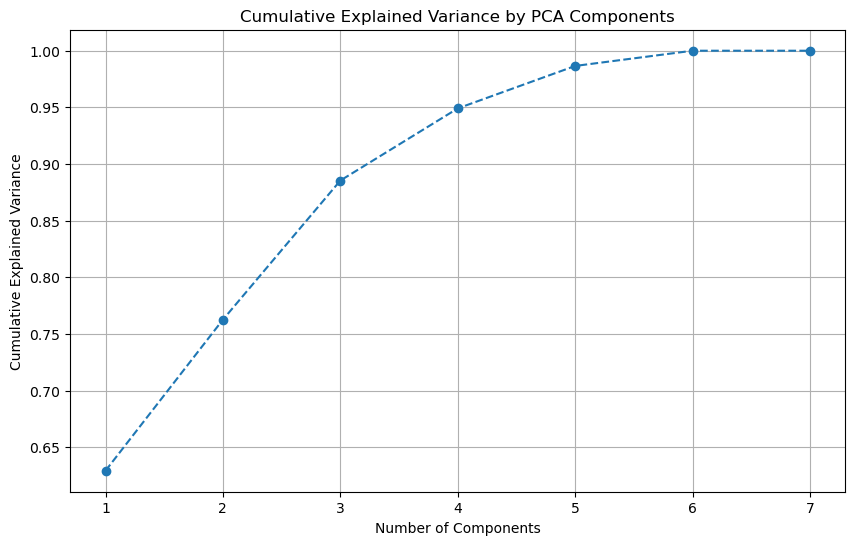

Cumulative explained variance by component:
[0.62934052 0.76266467 0.88542938 0.94910436 0.98656741 0.99999859
 1.        ]


In [32]:
spend_columns = [
    col for col in final_merged_data.columns 
    if 'spend' in col and col not in ('ad_spends_per_location', 'average_spends_per_cover')
]
spend_data = final_merged_data[spend_columns]

# Standardizing the data

scaler = StandardScaler()
spend_data_scaled = scaler.fit_transform(spend_data)

# Applying PCA

pca = PCA()
principal_components = pca.fit_transform(spend_data_scaled)
explained_variance_ratio = pca.explained_variance_ratio_

# Plotting the cumulative explained variance to decide on the number of principal components
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

cumulative_variance = np.cumsum(explained_variance_ratio)
print("Cumulative explained variance by component:")
print(cumulative_variance)


In [33]:
# PCA with 3 components based on above plot:

pca_3_components = PCA(n_components=3)
principal_components_3 = pca_3_components.fit_transform(spend_data_scaled)

# Extracting and displaying the first 3 principal components

loadings_retry = pd.DataFrame(pca_3_components.components_.T, 
                              columns=[f'PC{i+1}' for i in range(3)], 
                              index=spend_columns)
loadings_retry

,PC1,PC2,PC3
audience_network_spend,0.373617,-0.022978,-0.206694
device_unk_spend,0.167429,0.780062,0.596153
platform_unk_spend,0.180192,-0.625181,0.754598
total_social_spend,0.452494,-0.006833,-0.100757
total_mobile_spend,0.411748,-0.005913,-0.096609
total_age_category_spend,0.452267,-0.002075,-0.063571
total_spend,0.470186,-0.006171,-0.094516


In [34]:
pc_df = pd.DataFrame(principal_components_3, columns=[f'PC{i+1}' for i in range(3)])

# Drop spend-related columns from the original data to avoid multicollinearity

non_spend_data = final_merged_data.drop(columns=spend_columns)

# Combine the non-spend data with the principal components

combined_data = pd.concat([non_spend_data.reset_index(drop=True), pc_df], axis=1)

In [35]:
combined_data.columns

Index(['location', 'city', 'date', 'city_locations', 'covers', 'product',
       'menu_price', 'lifecycle_day', 'month', 'week', 'day_of_week',
       'quarter', 'day', 'is_weekend', 'year', 'dayofyear', 'weekofyear',
       'ad_spends_per_location', 'revenue_potential',
       'average_spends_per_cover', 'ROAS', 'covers_interaction_over_weekend',
       'covers_interaction_day_of_week', 'menu_price_segment', 'PC1', 'PC2',
       'PC3'],
      dtype='object')

In [36]:
combined_data_without_target = combined_data.drop(columns=['covers'])
vif_results = calculate_vif(combined_data_without_target, exclude_columns_suffix='is_weekend')
print(vif_results)

                            feature        VIF
2                        menu_price  26.301249
9    covers_interaction_day_of_week  18.990576
5                 revenue_potential  17.855739
4            ad_spends_per_location  17.452688
1                    city_locations  10.702314
10                              PC1   8.750945
0                          location   6.759969
8   covers_interaction_over_weekend   5.701135
7                              ROAS   4.051203
3                     lifecycle_day   3.871195
6          average_spends_per_cover   1.344444
12                              PC3   1.074154
11                              PC2   1.007909


In [37]:
combined_full_data = combined_data.copy()

Correlation values with 'covers':
covers                             1.000000
PC1                               -0.008289
PC2                               -0.005671
PC3                                0.011724
revenue_potential                  0.977765
ad_spends_per_location            -0.055957
covers_interaction_day_of_week     0.865509
menu_price                        -0.006415
city_locations                     0.144983
location                           0.117211
covers_interaction_over_weekend    0.655888
ROAS                               0.513294
lifecycle_day                      0.120430
average_spends_per_cover          -0.222708
Name: covers, dtype: float64


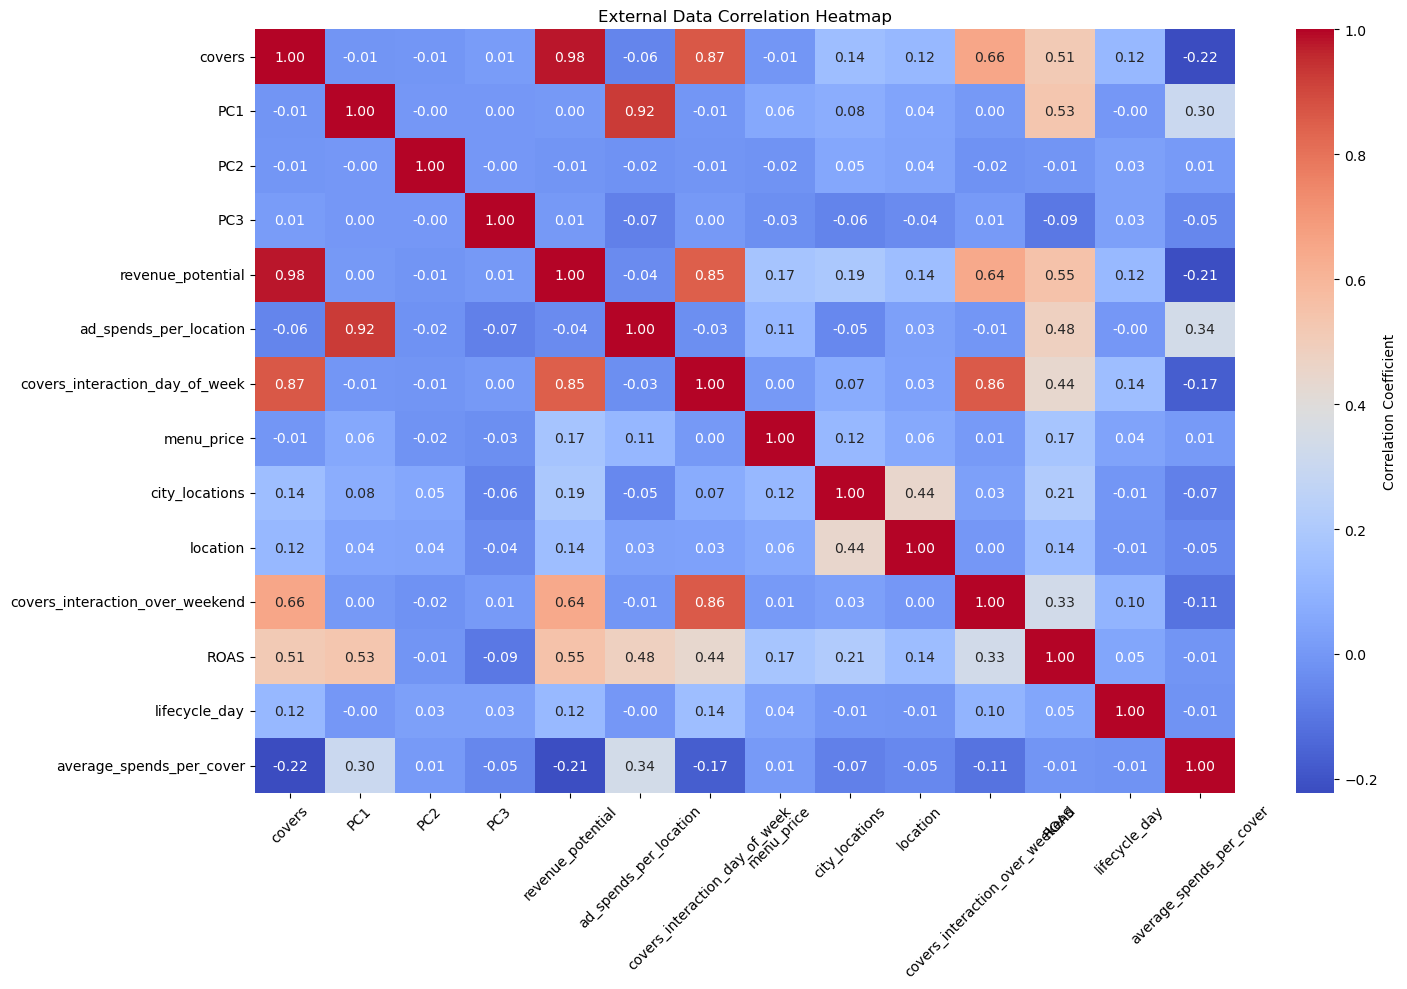

In [38]:
variables_to_analyze = ['PC1','PC2','PC3','revenue_potential','ad_spends_per_location',
                        'covers_interaction_day_of_week','menu_price','city_locations', 
                        'location', 'covers_interaction_over_weekend', 'ROAS', 'lifecycle_day',
                       'average_spends_per_cover']

analyze_correlation(combined_full_data, variables_to_analyze)

In [39]:
combined_full_data.drop(columns=['menu_price','ad_spends_per_location','covers_interaction_over_weekend'], 
                        axis=1, inplace = True)

In [40]:
combined_data_without_target = combined_full_data.drop(columns=['covers'])
vif_results = calculate_vif(combined_data_without_target, exclude_columns_suffix='is_weekend')
print(vif_results)

                          feature        VIF
3               revenue_potential  14.973008
6  covers_interaction_day_of_week   7.538315
1                  city_locations   7.503011
0                        location   6.166852
5                            ROAS   4.046255
2                   lifecycle_day   3.160119
7                             PC1   1.864928
4        average_spends_per_cover   1.250269
9                             PC3   1.031229
8                             PC2   1.002026


#### Feature importance through regression analysis

In [41]:
# Encoding 'city', 'product', and the quarter flags

combined_full_data1 = pd.get_dummies(combined_full_data, columns=['city', 'product', 'quarter','menu_price_segment'])

In [42]:
# Prepare data for regression

X = combined_full_data1.drop(['date', 'week', 'covers'], axis=1)  
X = sm.add_constant(X.astype(float))

# Target variable

y = combined_full_data1['covers']

# Splitting the dataset into training and testing sets

train_size = int(len(X) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Create OLS model

model = sm.OLS(y_train, X_train)

# Fit the model

results = model.fit()

# Summary of the model

print(results.summary())

# Predict on the test set

y_pred = results.predict(X_test)

# Calculate R^2 score

r2 = r2_score(y_test, y_pred)
print('R^2 score:', r2)


                            OLS Regression Results                            
Dep. Variable:                 covers   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     6072.
Date:                Sun, 28 Apr 2024   Prob (F-statistic):               0.00
Time:                        21:03:06   Log-Likelihood:                -7483.4
No. Observations:                2056   AIC:                         1.503e+04
Df Residuals:                    2025   BIC:                         1.520e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
location    

In [43]:
# Prepare the dataset with necessary features

model_data1 = combined_full_data1.set_index('date')[['location', 'city_locations', 'covers', 'lifecycle_day', 'week',
       'month', 'day_of_week', 'day', 'is_weekend', 'year', 'dayofyear',
       'weekofyear', 'average_spends_per_cover', 'ROAS',
       'covers_interaction_day_of_week', 'PC1', 'PC2', 'PC3', 'city_A',
       'city_B', 'city_C', 'city_D', 'city_E', 'product_American','revenue_potential',
       'product_Asian', 'product_European', 'product_Fantastical',
       'product_GTPWTW', 'product_Nostalgia', 'quarter_1', 'quarter_2',
       'quarter_3', 'quarter_4', 'menu_price_segment_High',
       'menu_price_segment_Low', 'menu_price_segment_Medium']].copy()


## Modelling: Sarimax

In [44]:
# Define the simplified SARIMAX model

simplified_sarimax_model = SARIMAX(
    model_data1['covers'],
    exog=model_data1[['is_weekend',
                      'average_spends_per_cover', 'ROAS','covers_interaction_day_of_week', 'PC1','revenue_potential']],
    order=(1, 1, 2),
    seasonal_order=(3, 0, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Fit the simplified model

simplified_sarimax_result = simplified_sarimax_model.fit(disp=False)

# Print the summary of the simplified model fit

simplified_sarimax_result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                              covers   No. Observations:                 2285
Model:             SARIMAX(1, 1, 2)x(3, 0, [1], 7)   Log Likelihood               -9552.792
Date:                             Sun, 28 Apr 2024   AIC                          19133.584
Time:                                     21:03:24   BIC                          19213.720
Sample:                                          0   HQIC                         19162.825
                                            - 2285                                         
Covariance Type:                               opg                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
is_weekend                       -15.7140      1.552    -10.124      0.000     -18.756     -12.672
average_spends_per_cover          -0.1628      0.037     -4.419      0.000      -0.235      -0.091
ROAS                              -0.5167      0.069     -7.488      0.000      -0.652      -0.381
covers_interaction_day_of_week     0.0368      0.002     19.246      0.000       0.033       0.041
PC1                                1.0274      0.268      3.832      0.000       0.502       1.553
revenue_potential                  0.0208      0.000     95.015      0.000       0.020       0.021
ar.L1                             -0.6871      0.616     -1.115      0.265      -1.895       0.520
ma.L1                             -0.2852      0.609     -0.469      0.639      -1.478       0.908
ma.L2                             -0.6871      0.598     -1.149      0.250      -1.859       0.485
ar.S.L7                            0.0983      0.295      0.333      0.739      -0.480       0.677
ar.S.L14                           0.0137      0.025      0.539      0.590      -0.036       0.064
ar.S.L21                          -0.0275      0.022     -1.226      0.220      -0.071       0.016
ma.S.L7                           -0.0648      0.297     -0.218      0.827      -0.647       0.517
sigma2                           307.2496     11.427     26.888      0.000     284.853     329.646
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                64.75
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                             0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Fit and train the model

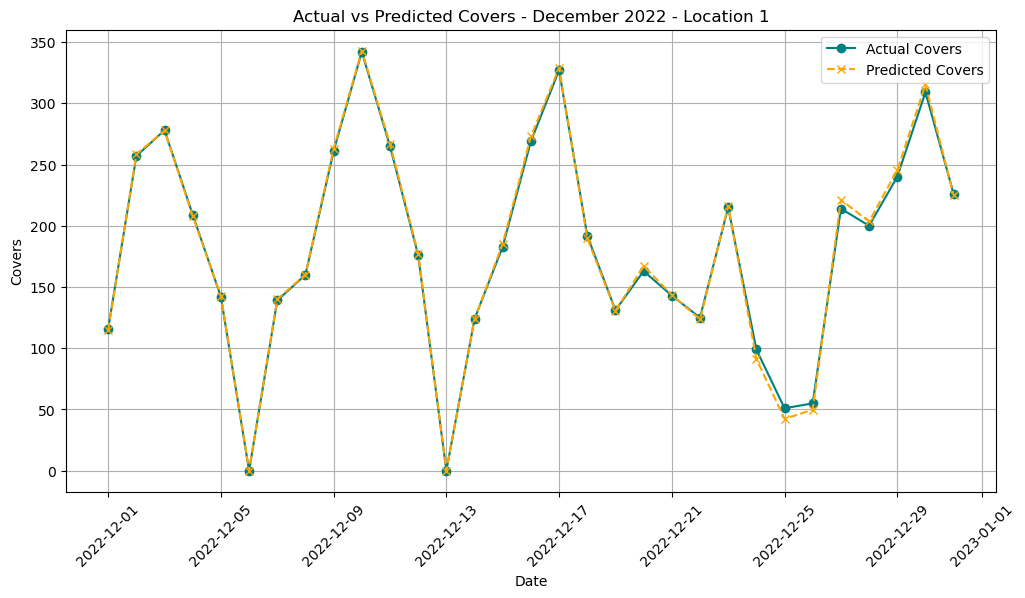

Location 1 - Train RMSE: 4.98, Train MAE: 3.47, Test RMSE: 3.42, Test MAE: 2.42


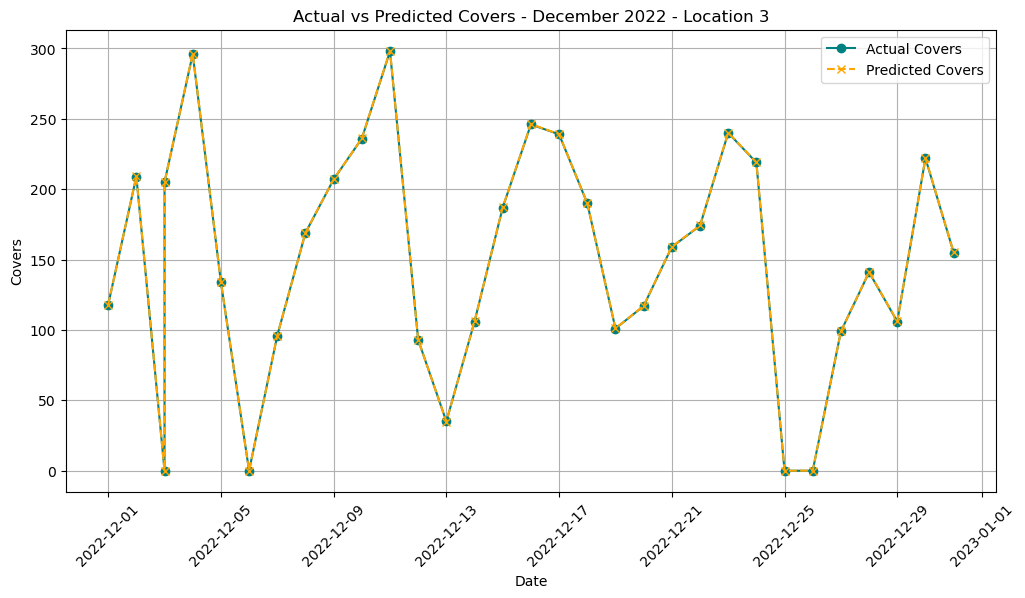

Location 3 - Train RMSE: 1.54, Train MAE: 0.57, Test RMSE: 0.18, Test MAE: 0.13


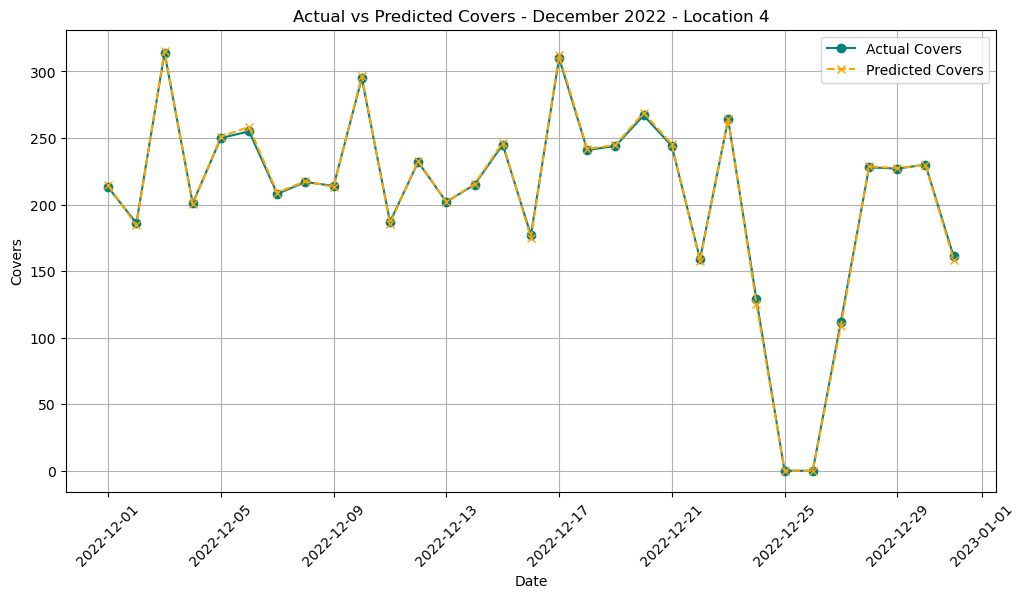

Location 4 - Train RMSE: 4.55, Train MAE: 3.00, Test RMSE: 1.57, Test MAE: 1.28


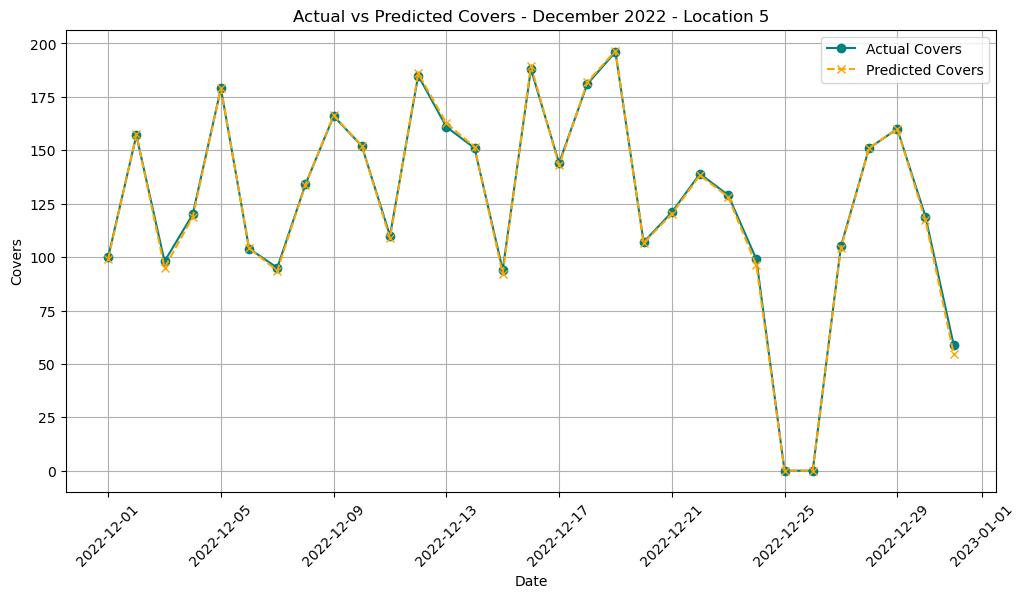

Location 5 - Train RMSE: 3.66, Train MAE: 2.60, Test RMSE: 1.38, Test MAE: 0.99


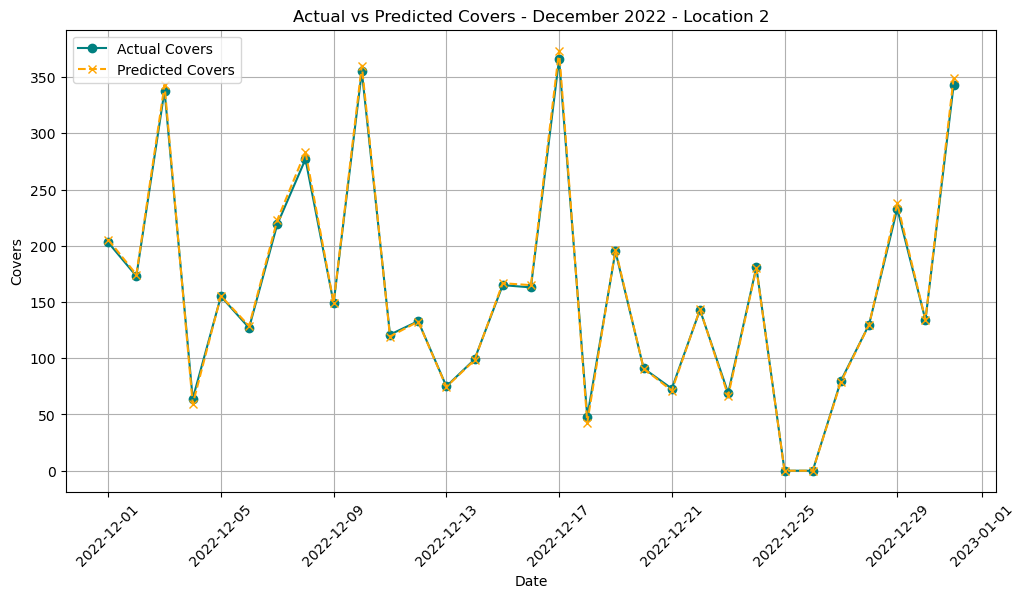

Location 2 - Train RMSE: 4.01, Train MAE: 2.93, Test RMSE: 3.18, Test MAE: 2.29


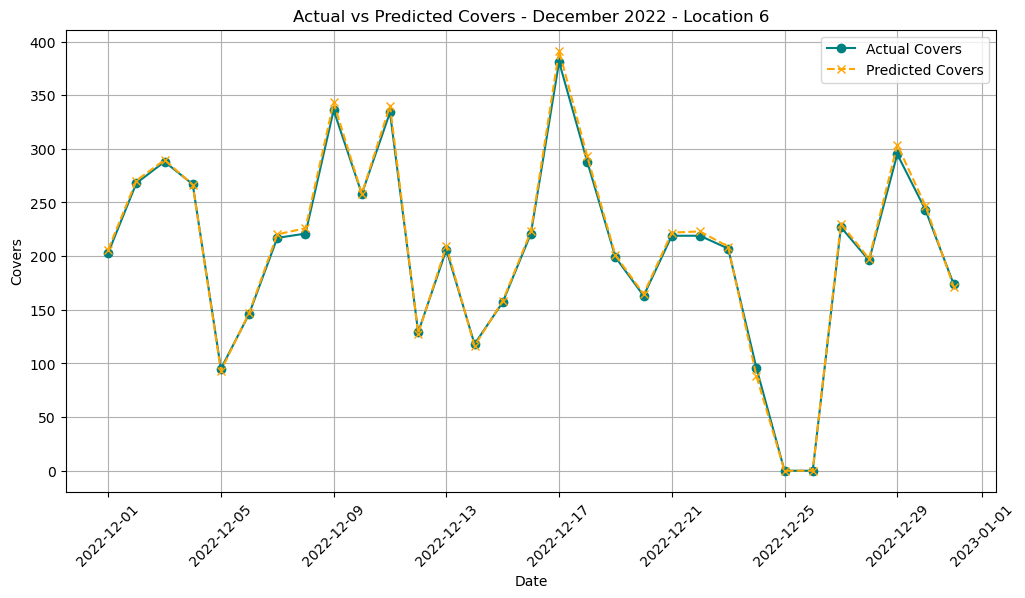

Location 6 - Train RMSE: 4.86, Train MAE: 3.52, Test RMSE: 4.06, Test MAE: 3.14
Average Train RMSE: 3.93, Average Train MAE: 2.68
Average Test RMSE: 2.30, Average Test MAE: 1.71


In [45]:
model_data1.index = pd.to_datetime(model_data1.index)

# Split the data into training and testing sets

train_end = pd.Timestamp('2022-11-30')
test_start = pd.Timestamp('2022-12-01')

train_data = model_data1.loc[model_data1.index <= train_end]
test_data = model_data1.loc[model_data1.index >= test_start]

# Initialize lists to store the RMSE and MAE values

test_rmse_list = []
test_mae_list = []
train_rmse_list = []
train_mae_list = []

# Initialize DataFrame to collect December predictions for all locations

december_forecasts = []

# Fit a SARIMAX model and predict for each location

unique_locations = model_data1['location'].unique()

for location in unique_locations:
    # Filter the training and testing data for this location
    
    train_location = train_data[train_data['location'] == location]
    test_location = test_data[test_data['location'] == location]

    # Define and fit the SARIMAX model
    
    model = SARIMAX(
        train_location['covers'],
        exog=train_location[['is_weekend', 'average_spends_per_cover', 'ROAS',
                             'covers_interaction_day_of_week', 'PC1','revenue_potential']],
        order=(1, 1, 2),
        seasonal_order=(3, 0, 1, 7),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    result = model.fit(disp=False)

    # Predict on the training set
    
    train_predicted = result.get_prediction(start=train_location.index[0], end=train_location.index[-1], 
                                            exog=train_location[['is_weekend', 'average_spends_per_cover', 
                                                                 'ROAS','covers_interaction_day_of_week',
                                                                 'PC1','revenue_potential']]).predicted_mean

    # Calculate RMSE and MAE for the training set
    
    train_rmse = sqrt(mean_squared_error(train_location['covers'], train_predicted))
    train_mae = mean_absolute_error(train_location['covers'], train_predicted)
    train_rmse_list.append(train_rmse)
    train_mae_list.append(train_mae)

    # Get the exogenous variables for December
    
    exog_test = test_location[['is_weekend', 'average_spends_per_cover', 'ROAS',
                             'covers_interaction_day_of_week', 'PC1','revenue_potential']]

    # Get the forecast for December
    
    forecast = result.get_forecast(steps=len(test_location), exog=exog_test)
    forecasted_covers = forecast.predicted_mean
    forecasted_covers = np.maximum(forecasted_covers, 0)
    
    # Calculate RMSE and MAE for the test set
    
    test_rmse = sqrt(mean_squared_error(test_location['covers'], forecasted_covers))
    test_mae = mean_absolute_error(test_location['covers'], forecasted_covers)
    test_rmse_list.append(test_rmse)
    test_mae_list.append(test_mae)

    # Store the actual and predicted covers in a DataFrame
    
    forecast_df = test_location[['covers']].copy()
    forecast_df['Predicted_Covers'] = forecasted_covers.values
    forecast_df['Location'] = location
    december_forecasts.append(forecast_df)

    # Plotting the actual vs predicted covers
    
    plt.figure(figsize=(12, 6))
    plt.plot(test_location.index, test_location['covers'], label='Actual Covers', color='teal', marker='o')
    plt.plot(test_location.index, forecasted_covers, label='Predicted Covers', color='orange', linestyle='--', marker='x')
    plt.title(f'Actual vs Predicted Covers - December 2022 - Location {location}')
    plt.xlabel('Date')
    plt.ylabel('Covers')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print training and testing metrics for location
    
    print(f'Location {location} - Train RMSE: {train_rmse:.2f}, Train MAE: {train_mae:.2f}, Test RMSE: {test_rmse:.2f}, Test MAE: {test_mae:.2f}')

# Concatenate all December forecast DataFrames

december_forecasts_df = pd.concat(december_forecasts)

# Calculate average RMSE and MAE across all locations for both training and testing

average_train_rmse = np.mean(train_rmse_list)
average_train_mae = np.mean(train_mae_list)
average_test_rmse = np.mean(test_rmse_list)
average_test_mae = np.mean(test_mae_list)
print(f'Average Train RMSE: {average_train_rmse:.2f}, Average Train MAE: {average_train_mae:.2f}')
print(f'Average Test RMSE: {average_test_rmse:.2f}, Average Test MAE: {average_test_mae:.2f}')

# Reset index to turn the DateTimeIndex into a column

december_forecasts_df.reset_index(inplace=True)
december_forecasts_df['Predicted_Covers'] = december_forecasts_df['Predicted_Covers'].round()


In [46]:
december_forecasts_df.head()

,date,covers,Predicted_Covers,Location
0,2022-12-01,116,115.0,1
1,2022-12-02,257,258.0,1
2,2022-12-03,278,278.0,1
3,2022-12-04,209,208.0,1
4,2022-12-05,142,143.0,1


In [47]:
# Save the model

joblib.dump(result, 'sarimax_model.pkl')

# Load the model
# loaded_model = joblib.load('sarimax_model.pkl')

['sarimax_model.pkl']

In [48]:
# save to CSV

december_forecasts_df.to_csv('december_predictions.csv', index=False)